# Глобальный и Локальный поиск
__Суммарное количество баллов: 10__

Во всех задачах нужно визуализировать минимальный путь и вывести его длину. 
Путь не циклический - начинается и заканчивается в разных точках.

ВНИМАНИЕ: расстояние нужно считать как L1, отрисовывать тоже как L1.

1. (1 балл) Реализуйте Монте-Карло поиск.
2. (1 балл) Реализуйте поиск случайным блужданием.
3. (2 балла) Реализуйте Hill Climb.
4. (3 балла) Реализуйте ожиг (simulated annealing). Температурный режим отжига выберите самостоятельно.
5. (3 балла) Реализуйте генетический алгоритм. 


In [1]:
from numpy import genfromtxt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import time
from random import randint
from random import random
import copy
from scipy.special import softmax

In [2]:
def read_dataset(path_to_csv):
    data = genfromtxt(path_to_csv, delimiter=',')
    return np.array(data[:,1:])

def draw_way(data, title, length):
    x = data[:,0:1].T[0]
    y = data[:,1:2].T[0]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['#2300A8', '#00A658', 'aquamarine']
    
    for i in range(len(data)-1):
        x1 = x[i]
        x2 = x[i+1]
        y1 = y[i]
        y2 = y[i+1]
        ax.plot([x1, x2],[y1, y1], c = colors[1])
        ax.plot([x2, x2],[y1, y2], c = colors[1])           
        
    
    ax.scatter(x, y, alpha = 0.7, c = colors[0], label = f'Length = {length}')
    ax.scatter(x[0], y[0], s = 100, c = colors[2], label = f'Ends')
    ax.scatter(x[-1], y[-1], s = 100, c = colors[2])
    
    #adds a title and axes labels
    ax.set_title(title)   
    leg = plt.legend(prop={'size': 13})

    plt.show()
    
def run_method(path, method, method_name, iters = 10000000):
    data = read_dataset(path)
    start = time()
    new_data, new_len = method(data, iters=iters)
    draw_way(new_data, method_name, new_len)
    print(f'{time()-start} sec')

Считать расстояние будем по L1 (Манхэттэновское расстояние) - реализуем подсчет:

In [3]:
def l1(p1, p2):
    return abs(p1[0]-p2[0])+abs(p1[1]-p2[1])

def total_l1(data):
    answer = 0
    for i in range(len(data)-1):
        answer += l1(data[i], data[i+1])
    return answer

### Monte-Carlo (1 балл)
Просто перемешаем `iter` количество раз, и выберем лучшее.

In [4]:
def monte_carlo(array, iters = 100000):
    min_len = total_l1(array)
    best_array = array
    for _ in range(iters):
        new_conf = array[np.random.permutation(array.shape[0]), :]
#         new_conf = np.random.shuffle(array)
        new_l1 = total_l1(new_conf)
        if new_l1 < min_len:
            print(new_l1, end = ' ')
            best_array = new_conf
            min_len = new_l1
    return best_array, min_len

### Random walk (1 балл)
__Random walk__ - идем из одной точки, запоминаем лучшее

In [5]:
def random_walk(array, iters = 100000):
    
    def neighbour_l1(i):
        answer = 0
        if i!=0:
            answer += l1(array[i], array[i-1])
        if i!=len(array)-1:
            answer += l1(array[i], array[i+1])
        return answer
    
    array = array[np.random.permutation(array.shape[0]), :]
    min_len = total_l1(array)
    best_array = copy.deepcopy(array)
    n = len(array)
    
    new_l1 = total_l1(array)

    for _ in range(iters):
        i1 = randint(0,n-1)
        i2 = randint(0,n-1)
        while i1==i2:
            i2 = randint(0,n-1)
        
        new_l1 -= neighbour_l1(i1) + neighbour_l1(i2)
        array[[i1, i2]] = array[[i2, i1]]
        new_l1 += neighbour_l1(i1) + neighbour_l1(i2)     
        if new_l1 < min_len:
            print(new_l1, end = ' ')
            best_array = copy.deepcopy(array)
            min_len = new_l1
    return best_array, min_len


### Hill-Climb (2 балла)
__Hill climb__ - осматриваем окрестность и ищем лучшее, переходим только в the best (похоже на рандом вок)

In [6]:
def try_all_switch(array, n, new_l1, min_len, best_array):
    def neighbour_l1(i):
        answer = 0
        if i!=0:
            answer += l1(array[i], array[i-1])
        if i!=len(array)-1:
            answer += l1(array[i], array[i+1])
        return answer
    
    
    for i1 in range(n):
        for i2 in range(n):
            if i1 == i2:
                continue
            this_l1 = new_l1
            new_l1 -= neighbour_l1(i1) + neighbour_l1(i2)
            array[[i1, i2]] = array[[i2, i1]]
            new_l1 += neighbour_l1(i1) + neighbour_l1(i2)     
            if new_l1 < min_len:
                print(new_l1, end = ' ')
                best_array = copy.deepcopy(array)
                min_len = new_l1
            array[[i1, i2]] = array[[i2, i1]]
            new_l1 = this_l1
    array = copy.deepcopy(best_array)
    new_l1 = min_len
    return array, new_l1, best_array, min_len



def hill_climb(array, iters = 100000):
    array = array[np.random.permutation(array.shape[0]), :]
    min_len = total_l1(array)
    best_array = copy.deepcopy(array)
    n = len(array)
    
    new_l1 = total_l1(array)

    for _ in range(iters):
        array, new_l1, best_array, min_len = try_all_switch(array, n, new_l1, min_len, best_array)
        
    return best_array, min_len

### Simulated annealing (3 балла)
__Simulated annealing__ - сколько то раз меняем температурный режим (т.е. количество перестановок).

In [7]:
def annealing(array, iters):
    array = array.tolist()
    n = len(array)
    best_array = copy.deepcopy(array)
    best_l1 = total_l1(best_array)
    l1_cur = best_l1 
    for _ in range(iters):
        for t in range(1000000, 1, -1):
            T = t/10000
            i1 = randint(0,n-1)
            i2 = randint(i1+1,n)
            array[i1: i2] = reversed(array[i1: i2])
            l1_new = total_l1(array)
            dE = l1_cur - l1_new
            if dE > 0 and np.exp(-dE/T) > random():
                l1_cur = l1_new
                if l1_cur < best_l1:
                    print(l1_cur, end = ' ')
                    best_l1 = l1_cur
                    best_array = copy.deepcopy(array)
            else:
                array[i1: i2] = reversed(array[i1: i2])
    return np.array(best_array), best_l1

### Genetic algorithm (3 балла)
__Genetic algorithm__ - ох-ох-ох.

In [8]:
def generate_pair(n):
    i1 = randint(0,n-1)
    return i1, randint(i1+1,n)

def crossingover(a1, a2):
    i1, i2 = generate_pair(len(a1))
    a_child = [[-1, -1] for i in range(len(a1))]
    a_child[i1:i2] = a1[i1:i2]
    pivot = 0
    for el in a2:
        if pivot == i1:
            pivot = i2
        if el not in a1[i1:i2]:
#             print(a1[i1:i2])
            a_child[pivot] = el
            pivot+=1 
    return a_child

    

def genetic_algo(array, iters):
    size = 500
    best_array = copy.deepcopy(array.tolist())
    best_l1 = total_l1(best_array)
    world = [array[np.random.permutation(array.shape[0]), :].tolist() for i in range(size)]
    n = len(array)
    for i in range(iters):
        # выберу поплуяцию - 10% лучших
        cur_relatives = sorted(world, key = total_l1)[0:size//10]
        world = []
        # сделаю потомство размером size
        for _ in range(size):
            p1, p2 = generate_pair(size//10-1)
            new_array = crossingover(cur_relatives[p1], cur_relatives[p2])
            new_l1 = total_l1(new_array)
            world.append(new_array)
            if new_l1<best_l1:
                print(new_l1, end = ' ')
                best_l1 = new_l1
                best_array = copy.deepcopy(new_array)
        # сделаю геномные перестройки у 5 процентов
        for _ in range(size//20):
            j = randint(0, size-1)
            i1, i2 = generate_pair(n)
            world[j][i1: i2] = reversed(world[j][i1: i2])
        # сделаю точечные мутации у 10 процентов
        for _ in range(size//20):
            j = randint(0, size-1)
            i1, i2 = generate_pair(n-1)
            world[j][i1], world[j][i2] = world[j][i2], world[j][i1]
                

    return np.array(best_array), best_l1

### Results
#### 0. Input distance.

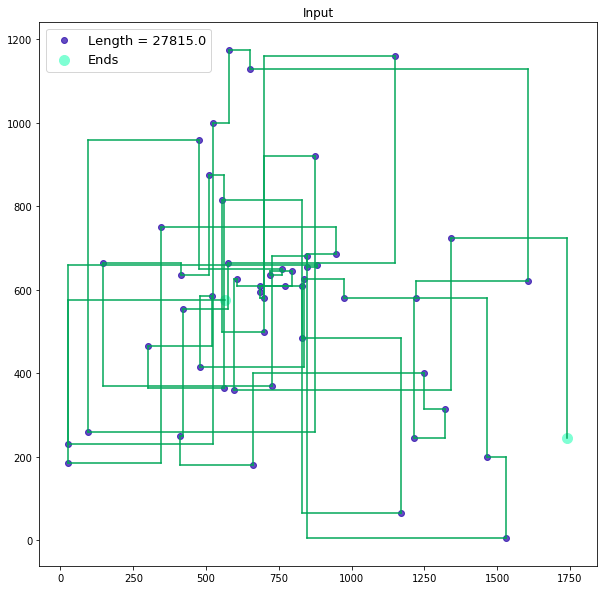

In [9]:
data = read_dataset('data/tsp.csv')
draw_way(data, 'Input', total_l1(data))

#### 1. Monte Carlo

27780.0 27320.0 26555.0 

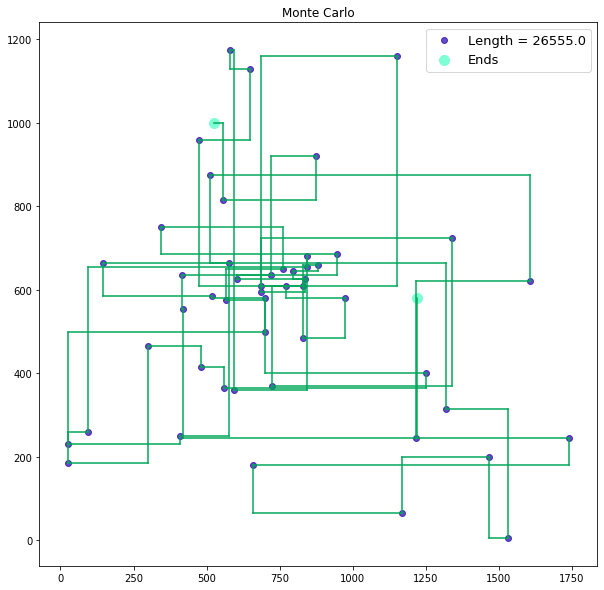

81.75291275978088 sec


In [10]:
run_method('data/tsp.csv', monte_carlo, 'Monte Carlo', 1000000)

#### 2. Random walk

40095.0 38915.0 38640.0 38450.0 37930.0 35960.0 35510.0 35430.0 35270.0 34960.0 33475.0 33090.0 32520.0 32040.0 31630.0 31560.0 31280.0 29270.0 29130.0 28560.0 28415.0 28185.0 27775.0 27025.0 26890.0 25890.0 25800.0 25110.0 24720.0 

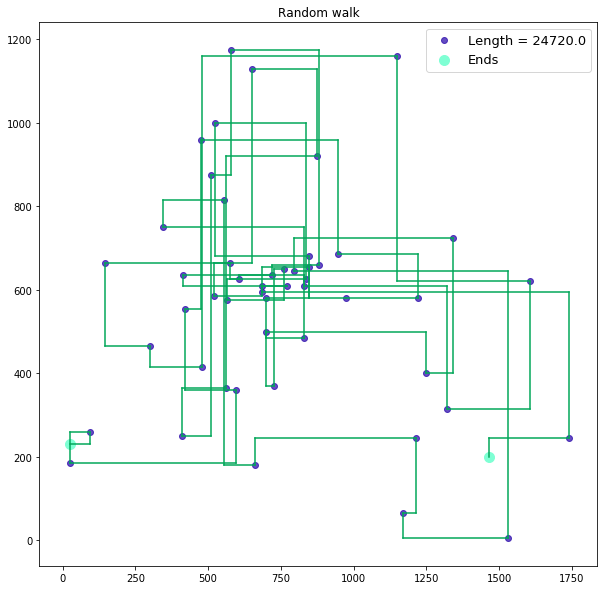

63.948251247406006 sec


In [11]:
run_method('data/tsp.csv', random_walk, 'Random walk', 3000000)

#### 3. Hill climb

37700.0 37210.0 37150.0 37000.0 36565.0 35975.0 35745.0 35625.0 35405.0 35145.0 34655.0 34480.0 33990.0 33930.0 33780.0 32755.0 32525.0 32405.0 32185.0 31925.0 31750.0 31260.0 31200.0 31050.0 30025.0 29795.0 29735.0 29625.0 29450.0 28960.0 28900.0 28750.0 28725.0 28275.0 28135.0 27495.0 26770.0 26620.0 26605.0 26295.0 25615.0 25475.0 25450.0 25365.0 24990.0 24740.0 24555.0 24395.0 24165.0 24135.0 24125.0 23985.0 23960.0 23875.0 23500.0 23335.0 23065.0 22905.0 22675.0 22535.0 22510.0 22425.0 22050.0 21885.0 21615.0 21455.0 21245.0 21105.0 21080.0 21045.0 21025.0 20950.0 20870.0 20755.0 20665.0 20625.0 20455.0 20185.0 20025.0 19885.0 19860.0 19825.0 19805.0 19730.0 19620.0 19445.0 19405.0 19185.0 19135.0 18995.0 18970.0 18935.0 18915.0 18795.0 18555.0 18515.0 18405.0 18375.0 18325.0 18185.0 18125.0 18105.0 18055.0 17985.0 17825.0 17595.0 17560.0 17395.0 17375.0 17315.0 17255.0 17125.0 17065.0 17030.0 16865.0 16845.0 16785.0 16725.0 16595.0 16395.0 16375.0 16205.0 16005.0 15985.0 15905.0 

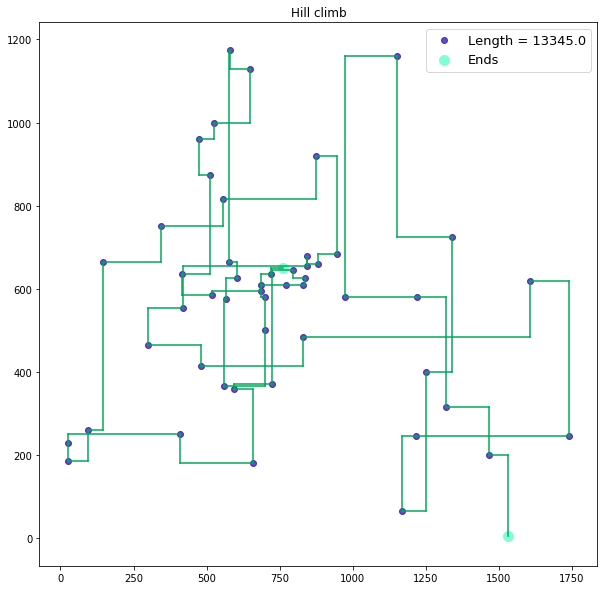

73.51540756225586 sec


In [12]:
run_method('data/tsp.csv', hill_climb, 'Hill climb', 1000)

#### 4. Annealing

27785.0 27765.0 27675.0 27535.0 27415.0 27375.0 27295.0 27285.0 27115.0 27085.0 27055.0 26955.0 26855.0 26755.0 26735.0 26475.0 26395.0 26345.0 26305.0 26295.0 26185.0 26125.0 26035.0 25905.0 25895.0 25825.0 25815.0 25765.0 25405.0 25395.0 25275.0 25245.0 25155.0 25095.0 25075.0 25030.0 25020.0 25005.0 24985.0 24755.0 24745.0 24715.0 24700.0 24690.0 24610.0 24310.0 24160.0 24030.0 23950.0 23900.0 23800.0 23720.0 23570.0 23560.0 23520.0 23450.0 23330.0 23260.0 23120.0 23090.0 23070.0 22960.0 22780.0 22720.0 22670.0 22630.0 22610.0 22530.0 22520.0 22450.0 22380.0 22260.0 22170.0 22130.0 22080.0 22000.0 21990.0 21770.0 21760.0 21560.0 21305.0 21225.0 21205.0 21165.0 21055.0 20950.0 20935.0 20925.0 20875.0 20845.0 20825.0 20785.0 20735.0 20675.0 20655.0 20560.0 20530.0 20520.0 20410.0 20310.0 20260.0 20140.0 19760.0 19640.0 19590.0 19580.0 19470.0 19390.0 19260.0 18930.0 18870.0 18790.0 18700.0 18640.0 18620.0 18560.0 18450.0 18420.0 18200.0 17940.0 17860.0 17665.0 17615.0 17535.0 17415.0 

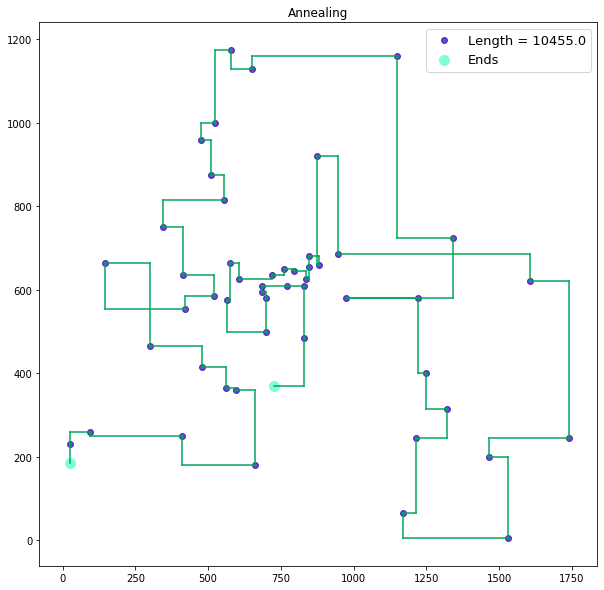

146.03920483589172 sec


In [13]:
run_method('data/tsp.csv', annealing, 'Annealing', 5)

#### 5. Genetic algo

27125.0 26910.0 26730.0 26585.0 25950.0 25815.0 25665.0 25640.0 24770.0 24510.0 23440.0 22990.0 22775.0 22390.0 22135.0 21680.0 21170.0 21120.0 21115.0 20485.0 20210.0 19365.0 19115.0 18440.0 18305.0 18255.0 17570.0 17460.0 16145.0 16125.0 15790.0 15050.0 14950.0 14440.0 14380.0 14330.0 14180.0 14080.0 13610.0 13420.0 13400.0 13200.0 13180.0 13140.0 12890.0 12680.0 12650.0 12460.0 12410.0 12390.0 12280.0 12250.0 12200.0 12130.0 12080.0 12040.0 12020.0 11810.0 11670.0 11620.0 11570.0 11560.0 11540.0 11460.0 11450.0 11350.0 11340.0 11260.0 11240.0 11150.0 11090.0 11050.0 10770.0 10750.0 10710.0 10650.0 10620.0 10610.0 10560.0 10460.0 10420.0 10400.0 10340.0 10020.0 9990.0 9910.0 9700.0 9690.0 9400.0 

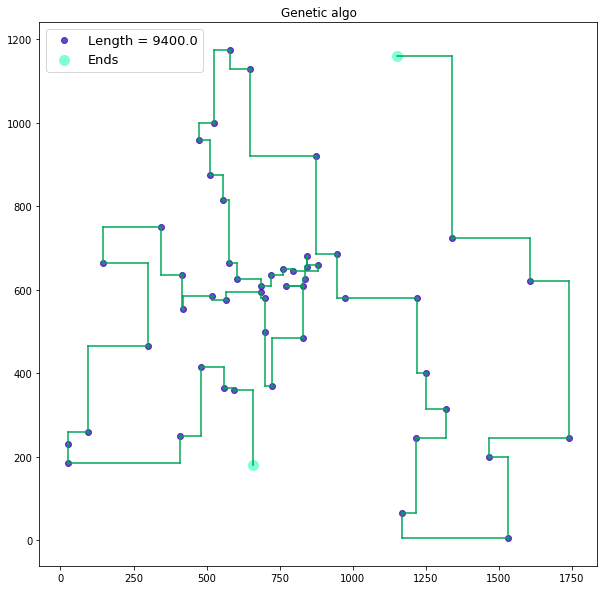

137.13818645477295 sec


In [14]:
run_method('data/tsp.csv', genetic_algo, 'Genetic algo', 3000)